In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import float32, zeros, ones, eye, as_tensor, tensor

from sbi.inference import MCMCPosterior, VIPosterior, ImportanceSamplingPosterior
from sbi.analysis import pairplot
from sbi.utils import mcmc_transform

from gbi.GBI import GBInference
from gbi.hh.train_gbi import MaeDistZ
import gbi.hh.utils as utils
from gbi.hh.HodgkinHuxley import HodgkinHuxley
from gbi.hh.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments

/home/michael/anaconda3/envs/gbi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Main figure is with 1 Million simulations

In [3]:
gbi_path = "/home/michael/Documents/neuralgbi/results/hh/gbi/2023_05_06__09_59_25_m/0_nsims_1000000"
npe_path = "/home/michael/Documents/neuralgbi/results/hh/npe/2023_05_07__12_29_21"

In [4]:
with open(f"{gbi_path}/inference_gbi.pkl", "rb") as handle:
    inference_gbi = pickle.load(handle)
with open(f"{npe_path}/inference_npe.pkl", "rb") as handle:
    inference_npe = pickle.load(handle)

### Load simulator

In [5]:
seed = 1
n_xcorr = 0
n_mom = 4
n_summary = 7

In [6]:
true_params, labels_params = utils.obs_params(reduced_model=False)
I, t_on, t_off, dt = utils.syn_current()
obs = utils.syn_obs_data(I, dt, true_params, seed=0, cython=True)

sim = HodgkinHuxley(
    I, dt, V0=obs["data"][0], reduced_model=False, cython=True, prior_log=False
)
stats = HodgkinHuxleyStatsMoments(
    t_on=t_on, t_off=t_off, n_xcorr=n_xcorr, n_mom=n_mom, n_summary=n_summary
)

### Load prior

In [7]:
prior = utils.prior(
    true_params=true_params,
    prior_uniform=True,
    prior_extent=True,
    prior_log=False,
    seed=0,
)
limits = torch.stack(
    [
        prior.support.base_constraint.lower_bound,
        prior.support.base_constraint.upper_bound,
    ]
).T

### Load allen cell data

In [19]:
obs_stats_ls = utils.load_all_allen()

In [20]:
obs_stats_ls

[array([[ 1.20000000e+01, -8.66186218e+01,  5.81934974e-02,
         -5.97431755e+01,  7.35669098e+01,  5.71116078e+00,
          4.96576490e+01]]),
 array([[ 2.50000000e+01, -8.11308136e+01,  8.70103464e-02,
         -5.29775391e+01,  1.57606781e+02,  3.93246800e+00,
          1.91559262e+01]]),
 array([[ 2.00000000e+01, -7.41032715e+01,  8.94342810e-02,
         -5.87518806e+01,  9.98759613e+01,  5.61000948e+00,
          4.02603960e+01]]),
 array([[ 1.10000000e+01, -8.86418533e+01,  3.62796932e-02,
         -6.00989151e+01,  6.68871994e+01,  5.69478340e+00,
          5.50093227e+01]]),
 array([[ 1.20000000e+01, -8.52603302e+01,  6.09806292e-02,
         -6.00998802e+01,  8.83744965e+01,  5.42692789e+00,
          4.41310047e+01]]),
 array([[ 1.80000000e+01, -9.00500717e+01,  4.43019308e-02,
         -5.51991768e+01,  1.30439011e+02,  4.62098051e+00,
          2.90312664e+01]]),
 array([[ 1.30000000e+01, -7.65611801e+01,  6.66750297e-02,
         -5.52036591e+01,  6.00890617e+01,  5.

In [21]:
a = torch.as_tensor(np.concatenate(obs_stats_ls), dtype=torch.float32)

In [22]:
a = a.repeat((100, 1))

In [24]:
a.shape

torch.Size([1000, 7])

In [9]:
with open("data/theta.pkl", "rb") as handle:
    theta = pickle.load(handle)

with open("data/summstats.pkl", "rb") as handle:
    x = pickle.load(handle)

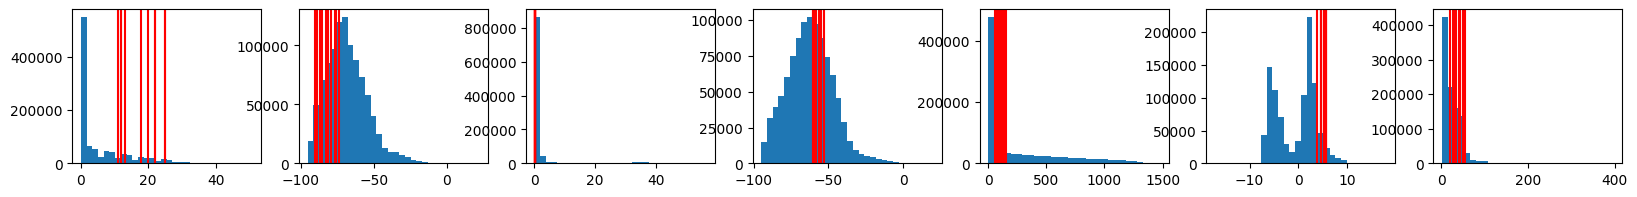

In [10]:
fig, ax = plt.subplots(1, 7, figsize=(20, 2))
for i in range(7):
    _ = ax[i].hist(x[:, i].numpy(), bins=30)
    for o in obs_stats_ls:
        ax[i].axvline(o[0, i], c="r")

# GBI

### Evaluate the distance estimator

In [11]:
# Generate 10 simulations for 100 thetas
theta_vals = prior.sample((100,))
seeds = torch.randint(0, 100000, (100, 10))
final_stats = []
for theta_ind, theta_val in enumerate(theta_vals):
    all_summstats = []
    for iter_ in range(10):  # 10 sims per theta
        x_val = sim.gen_single(theta_val, seed=seeds[theta_ind, iter_])
        summstats = stats.calc([x_val])
        all_summstats.append(summstats)
    final_stats.append(all_summstats)

final_stats = np.asarray(final_stats)
final_stats = torch.as_tensor(final_stats, dtype=torch.float32)
final_stats = final_stats.squeeze()
print("final_stats", final_stats.shape)

final_stats torch.Size([100, 10, 7])


In [12]:
theta_vals.shape

torch.Size([100, 8])

In [13]:
# Generate 10 synthetic observations
theta_vals_target = prior.sample((10,))
seeds = torch.randint(0, 100000, (10,))
x_target_vals = []
for theta_ind, theta_val in enumerate(theta_vals_target):
    x_val = sim.gen_single(theta_val, seed=seeds[theta_ind])
    summstats = stats.calc([x_val])
    x_target_vals.append(summstats)

x_target_vals = np.asarray(x_target_vals)
x_target_vals = torch.as_tensor(x_target_vals, dtype=torch.float32)
print("x_target_vals", x_target_vals.shape)

x_target_vals torch.Size([10, 1, 7])


In [14]:
pred_dists = np.asarray([inference_gbi.predict_distance(theta_vals, x_target_val).detach().numpy() for x_target_val in x_target_vals])
true_dists = np.asarray([inference_gbi.distance_func(final_stats, x_target_val).numpy() for x_target_val in x_target_vals])

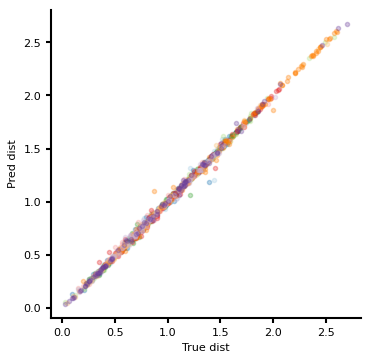

In [15]:
cols = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
]
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    for i in range(10):
        t = true_dists[i]
        p = pred_dists[i]
        _ = ax.scatter(t, p, c=cols[i], alpha=.3)
        _ = ax.set_xlabel("True dist")
        _ = ax.set_ylabel("Pred dist")
    plt.savefig("svg/panel_aa.svg")

### Draw samples from posterior

In [16]:
def sample_gbi_all_xo(beta):
    all_samples = []
    for xo in obs_stats_ls:
        xo = as_tensor(xo)
        potential_fn = inference_gbi.get_potential(x_o=xo, beta=beta)
        theta_transform = mcmc_transform(prior)

        posterior = MCMCPosterior(
            potential_fn,
            theta_transform=theta_transform,
            proposal=prior,
            method="slice_np_vectorized",
            thin=10,
            warmup_steps=100,
            num_chains=100,
            init_strategy="resample",
            frac_chains_to_finish=0.9,
        )
        posterior_samples = posterior.sample((1_000,), frac_chains_to_finish=0.9)
        all_samples.append(posterior_samples)
    return all_samples

In [17]:
betas = [10.0, 50.0, 250.0]

In [18]:
# samples_gbi_beta10 = sample_gbi_all_xo(betas[0])
# samples_gbi_beta50 = sample_gbi_all_xo(betas[1])
# samples_gbi_beta250 = sample_gbi_all_xo(betas[2])
# with open("samples_gbi_beta10.pkl", "wb") as handle:
#     pickle.dump(samples_gbi_beta10, handle)
# with open("samples_gbi_beta50.pkl", "wb") as handle:
#     pickle.dump(samples_gbi_beta50, handle)
# with open("samples_gbi_beta250.pkl", "wb") as handle:
#     pickle.dump(samples_gbi_beta250, handle)

In [47]:
with open("samples_gbi_beta10.pkl", "rb") as handle:
    samples_gbi_beta10 = pickle.load(handle)
with open("samples_gbi_beta50.pkl", "rb") as handle:
    samples_gbi_beta50 = pickle.load(handle)
with open("samples_gbi_beta250.pkl", "rb") as handle:
    samples_gbi_beta250 = pickle.load(handle)

### Posterior predictives

In [48]:
all_predictive_stats_gbi250 = []
all_predictive_traces_gbi250 = []
for posterior_samples in samples_gbi_beta250:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
    stats_ = stats.calc(r)
    all_predictive_stats_gbi250.append(torch.as_tensor(stats_, dtype=torch.float32))
    all_predictive_traces_gbi250.append(r)

all_predictive_stats_gbi50 = []
all_predictive_traces_gbi50 = []
for posterior_samples in samples_gbi_beta50:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
    stats_ = stats.calc(r)
    all_predictive_stats_gbi50.append(torch.as_tensor(stats_, dtype=torch.float32))
    all_predictive_traces_gbi50.append(r)

all_predictive_stats_gbi10 = []
all_predictive_traces_gbi10 = []
for posterior_samples in samples_gbi_beta10:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
    stats_ = stats.calc(r)
    all_predictive_stats_gbi10.append(torch.as_tensor(stats_, dtype=torch.float32))
    all_predictive_traces_gbi10.append(r)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

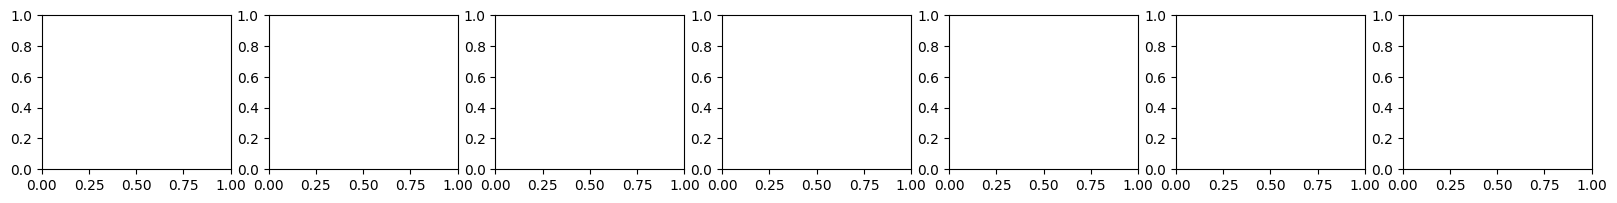

In [50]:
fig, ax = plt.subplots(1, 7, figsize=(20, 2))
for i in range(7):
    _ = ax[i].hist(x[:, i].numpy(), bins=30, density=True)
    _ = ax[i].hist(all_predictive_stats_gbi250[0].numpy()[:, i], bins=30, density=True)
    _ = ax[i].axvline(obs_stats_ls[0][0, i], c="r")

In [39]:
gbi250_av_dists = []
for predictives, xo in zip(all_predictives_gbi250, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi250_av_dists.append(torch.mean(dists))

gbi50_av_dists = []
for predictives, xo in zip(all_predictives_gbi50, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi50_av_dists.append(torch.mean(dists))

gbi10_av_dists = []
for predictives, xo in zip(all_predictives_gbi10, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi10_av_dists.append(torch.mean(dists))

NameError: name 'all_predictives_gbi250' is not defined

In [48]:
all_obs[2]["dt"]

0.02

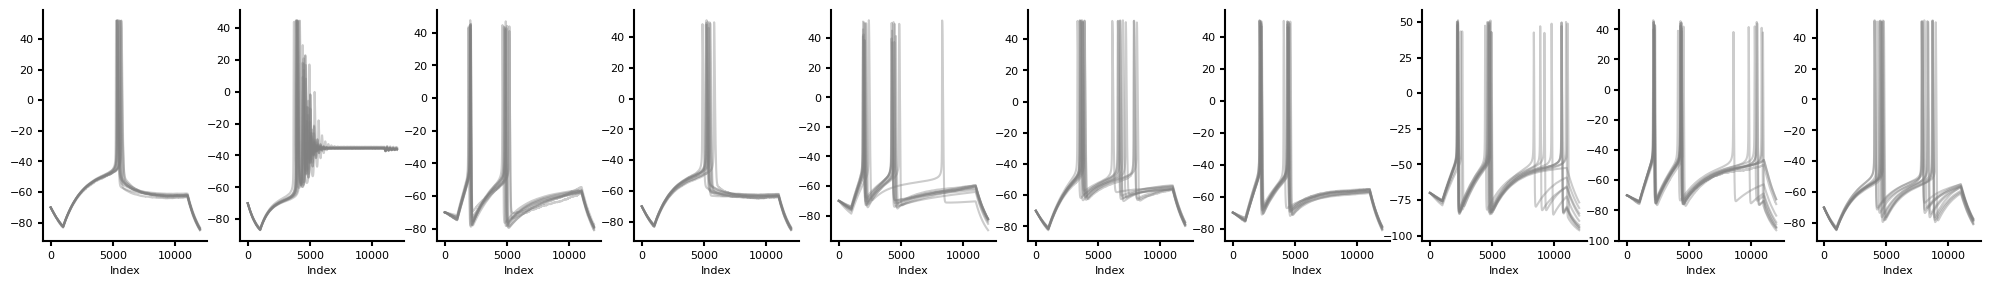

In [54]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 10, figsize=(25, 3))
    for i in range(10):
        predictives = all_predictive_traces_gbi250[i]
        xo  = all_obs[i]
        for p in predictives[:10]:
            _ = ax[i].plot(p["data"], c="grey", alpha=0.4)
            
#         _ = ax[i].plot(xo["data"], c="k")
        _ = ax[i].set_xlabel("Index")
        _ = ax[i].set_ylabel("")  # "Voltage (mV)")
        plt.savefig("svg/panel_b.svg")

# NPE

In [82]:
npe_all_samples = []
maps = []
for xo in obs_stats_ls:
    xo = as_tensor(xo)
    posterior = inference_npe.build_posterior()
    posterior_samples = posterior.sample((1_000,), x=xo)
    npe_all_samples.append(posterior_samples)
    maps.append(posterior.set_default_x(xo).map())

Drawing 1000 posterior samples: 100%|████████████████████████████████████████████| 1000/1000 [00:00<00:00, 43195.27it/s]


In [84]:
maps

[tensor([1.0851e+01, 5.3236e+00, 5.9961e-01, 1.0278e-04, 2.9998e+03, 7.6834e+01,
         1.4490e-01, 7.9770e+01]),
 tensor([1.1566e+01, 6.9645e+00, 5.9966e-01, 1.0388e-04, 5.2019e+02, 7.5276e+01,
         1.4771e-01, 7.2180e+01]),
 tensor([1.5900e+01, 8.5395e+00, 6.0000e-01, 1.1355e-04, 2.9968e+03, 7.8991e+01,
         1.4982e-01, 6.8362e+01]),
 tensor([1.1561e+01, 5.4994e+00, 5.9999e-01, 1.0067e-04, 2.9956e+03, 7.8483e+01,
         1.4391e-01, 8.0806e+01]),
 tensor([1.0343e+01, 4.7526e+00, 5.9958e-01, 1.1755e-04, 2.9952e+03, 7.7642e+01,
         1.4633e-01, 7.9212e+01]),
 tensor([1.0036e+01, 6.1031e+00, 5.9963e-01, 1.0055e-04, 4.1073e+02, 7.6066e+01,
         1.4902e-01, 8.1085e+01]),
 tensor([1.1096e+01, 6.8909e+00, 6.0000e-01, 1.0142e-04, 2.9987e+03, 7.2286e+01,
         1.4918e-01, 7.1277e+01]),
 tensor([1.6012e+01, 8.2314e+00, 5.9999e-01, 1.0230e-04, 4.3752e+02, 8.1359e+01,
         1.4985e-01, 6.5093e+01]),
 tensor([1.2500e+01, 6.9737e+00, 5.9999e-01, 1.0143e-04, 4.7223e+02, 7.8

In [91]:
all_map_traces = []
for map_ in maps:
    r = [sim.gen_single(map_.numpy(), seed=2)]
    all_map_traces.append(r)

In [60]:
all_predictive_traces = []
all_predictive_stats = []
for posterior_samples in npe_all_samples:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples[:100]]
    all_predictive_traces.append(r)
    stats_ = stats.calc(r)
    all_predictive_stats.append(torch.as_tensor(stats_, dtype=torch.float32))

In [61]:
npe_av_dists = []
for predictives, xo in zip(all_predictive_stats, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    npe_av_dists.append(torch.mean(dists))

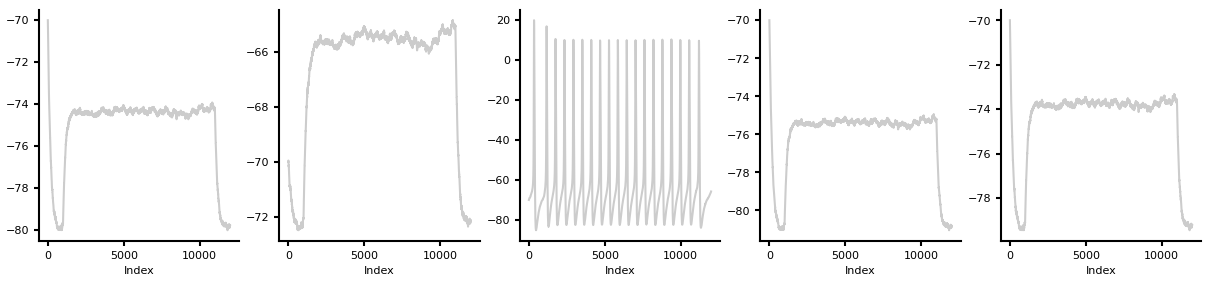

In [92]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        predictives = all_predictive_traces[i]
        xo  = all_obs[i]
        for p in predictives[:1]:
            _ = ax[i].plot(p["data"], c="grey", alpha=0.4)
        _ = ax[i].set_xlabel("Index")
        plt.savefig("svg/panel_a.svg")

# Compare NPE and GBI

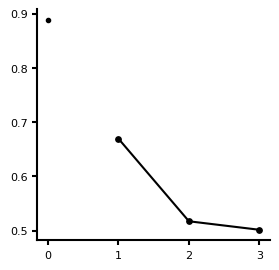

In [71]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    _ = ax.scatter([0], [np.mean(npe_av_dists)], c="k")
    _ = ax.plot([1, 2, 3], [np.mean(gbi10_av_dists), np.mean(gbi50_av_dists), np.mean(gbi250_av_dists)])
    _ = ax.scatter([1, 2, 3], [np.mean(gbi10_av_dists), np.mean(gbi50_av_dists), np.mean(gbi250_av_dists)], s=15)
    plt.savefig("svg/panel_c.svg")

/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarning: No contour levels were found within the data range.
  plt.contour(
/home/michael/Documents/neuralgbi/packages/sbi/sbi/analysis/plot.py:390: UserWarni

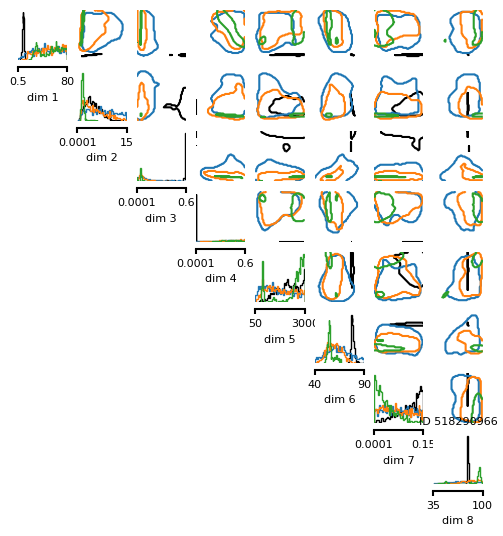

In [74]:
with mpl.rc_context(fname="../../.matplotlibrc"):
    fig, ax = pairplot(
        [
            npe_all_samples[0], 
            samples_gbi_beta10[0], 
            samples_gbi_beta50[0], 
            samples_gbi_beta250[0], 
        ],
        limits=limits,
        ticks=limits,
        upper="contour",
        contour_offdiag={"levels": [0.68], "percentile": True},
        figsize=(6, 6),
    )
    plt.title(f"ID {list_cells_AllenDB[0][0]}")
    plt.savefig("svg/panel_d.svg")

### Assemble figure

In [75]:
import time
import IPython.display as IPd
from svgutils.compose import *

In [80]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("25.3cm", "17.1cm",
           
    Panel(
          SVG("svg/illustration.svg").scale(svg_scale),
          Text("a", -5, 2.0, **kwargs_text),
    ).move(10, 20),
           
    Panel(
          SVG("svg/panel_aa.svg").scale(svg_scale),
          Text("b", -5, 2.0, **kwargs_text),
    ).move(10, 20),
           
    Panel(
          SVG("svg/panel_a.svg").scale(svg_scale),
          Text("b", -5, 2.0, **kwargs_text),
    ).move(10, 20),
    
    Panel(
          SVG("svg/panel_b.svg").scale(svg_scale),
          Text("c", -5, 2.0, **kwargs_text),
    ).move(400, 20),
           
    Panel(
          SVG("svg/panel_c.svg").scale(svg_scale),
          Text("d", -5, 2.0, **kwargs_text),
    ).move(400, 20),
           
    Panel(
          SVG("svg/panel_d.svg").scale(svg_scale),
          Text("e", -5, 2.0, **kwargs_text),
    ).move(400, 20),
)

!mkdir -p fig
f.save("fig/fig.svg")
svg("fig/fig.svg")